#ML Course Regression Assignment: Predicting Housing Prices

## Dataset: Boston Housing Prices

In this assignment, you will explore a dataset of housing prices and use regression to predict house prices based on various features. You will also perform exploratory data analysis (EDA), visualize the data, and select important features.

### Instructions:
- Answer the following questions by writing code in the cells below.
- Be sure to visualize your findings and explain your reasoning.
- Finally, train a regression model to predict housing prices and evaluate its performance.

---

## **1. Data Loading and Exploration**

### Question 1: Load the dataset and inspect the first few rows.
- Load the Boston housing dataset (from `sklearn.datasets`) into a pandas DataFrame.
Since the **Boston Housing dataset** is deprecated, you can download the alternative housing dataset from [Kaggle Housing Prices Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) if necessary.

- Display the first 5 rows to understand the structure of the data.



In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [237]:
df = pd.read_csv('Data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Question 2: Check for missing values.
- Identify if there are any missing values in the dataset. How would you handle them if any exist?


In [238]:
num_cols_na_count = df.select_dtypes(include='number').isnull().sum()       # count NaNs in numerical columns
num_cols_with_na_count = num_cols_na_count[num_cols_na_count > 0]           # filter numerical columns with NaNs
print(f"The dimensionality of the dataframe: {df.shape}\n")
print(f"NaN counts for numerical columns:\n\n{num_cols_with_na_count}")

The dimensionality of the dataframe: (1460, 81)

NaN counts for numerical columns:

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64


In [239]:
num_cols_with_na = num_cols_with_na_count.index.tolist()                    # list of columns with NaNs
df[num_cols_with_na].describe().round(1)                                    # basic descriptive statistics

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.0,1452.0,1379.0
mean,70.0,103.7,1978.5
std,24.3,181.1,24.7
min,21.0,0.0,1900.0
25%,59.0,0.0,1961.0
50%,69.0,0.0,1980.0
75%,80.0,166.0,2002.0
max,313.0,1600.0,2010.0


Skewness of LotFrontage: 2.16


<Axes: xlabel='LotFrontage', ylabel='Count'>

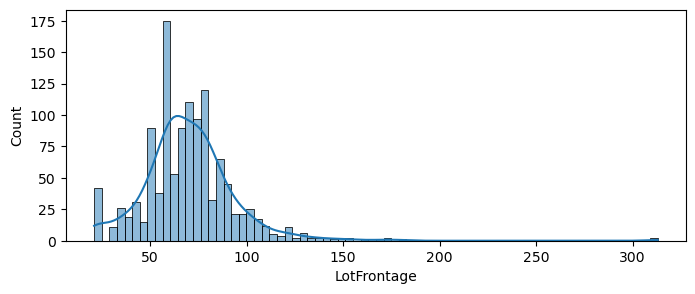

In [240]:
# Check the distribution of the LotFrontage (Linear feet of street connected to property) feature
from scipy.stats import skew
skewness = skew(df['LotFrontage'].dropna())
print(f"Skewness of LotFrontage: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['LotFrontage'].dropna(), kde=True)

Skewness of SalePrice: 1.88


<Axes: xlabel='SalePrice', ylabel='Count'>

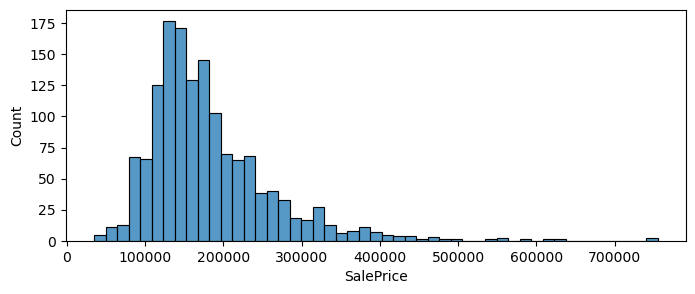

In [241]:
# Check additionaly the distribution of the target variable SalePrice
skewness = skew(df['SalePrice'])
print(f"Skewness of SalePrice: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['SalePrice'])

In [242]:
# The skewness of LotFrontage exceeds 2 which suggests substantial nonnormality. Imputing the mean looks not justified. 
# The skewness of the target feature is as well relatively high. Let's compare its median values for missing and present LotFrontage values to decide on the imputation strategy.

median_missing = df.loc[df['LotFrontage'].isna(), 'SalePrice'].median()
median_present = df.loc[df['LotFrontage'].notna(), 'SalePrice'].median()

print(f"Missing LotFrontage ({df['LotFrontage'].isna().shape[0]} rows): Median SalePrice: {median_missing:.2f}")
print(f"Present LotFrontage ({df['LotFrontage'].notna().shape[0]} rows): Median SalePrice: {median_present:.2f}")
print(f"Difference (Missing - Present): {median_missing - median_present:.2f}")

Missing LotFrontage (1460 rows): Median SalePrice: 172400.00
Present LotFrontage (1460 rows): Median SalePrice: 159500.00
Difference (Missing - Present): 12900.00


The 12900 median SalePrice difference suggests missingness is informative. Filling with the mean (or even median) of LotFrontage ignores this pattern and could bias the model by assuming missing values behave like present ones, which they don’t (higher median SalePrice).
To account for this factor let's introduce a new binary feature to flag missingness in addition to filling the original column with median values.

In [243]:
df['LotFrontage_missing'] = df['LotFrontage'].isna().astype(int)            # 1 if LotFrontage is missing, 0 otherwise
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())    # impute the median value

Let's now evaluate how the imputation of LotFrontage affected its correlation with SalePrice

In [244]:
# Correlation between LotFrontage (post-imputation) and SalePrice
correlation = df['LotFrontage'].corr(df['SalePrice'])
print(f"Correlation between LotFrontage (post-imputation) and SalePrice: {correlation:.3f}")

# For comparison, compute correlation pre-imputation (on non-missing data)
correlation_pre = df.loc[df['LotFrontage_missing'] == 0, 'LotFrontage'].corr(df.loc[df['LotFrontage_missing'] == 0, 'SalePrice'])
print(f"Correlation between LotFrontage (pre-imputation) and SalePrice: {correlation_pre:.3f}")

Correlation between LotFrontage (post-imputation) and SalePrice: 0.335
Correlation between LotFrontage (pre-imputation) and SalePrice: 0.352


Impact of Imputation:
- The drop from 0.352 to 0.335 is small (~4.8% relative decrease). This suggests that median imputation didn’t significantly distort the relationship between LotFrontage and SalePrice.
- However, even this slight decrease indicates that the imputation introduced a bit of noise. The 259 imputed values (17.7% of the data) are all set to the median, which reduces the variability in LotFrontage and slightly weakens its linear relationship with SalePrice.

- As an alternative we can try to implement regression imputation to predict missing LotFrontage values using other features correlated with them. 
- This might better preserve the relationship with SalePrice by imputing values that reflect patterns in the data.
- Then we will compare which approach turns to be more efficient.
- For this purpose let's first extract a few numerical features which show the strongest association with LotFrontage.

In [245]:
# Select numerical features and compute the correlation matrix
corr_matrix = df.select_dtypes(include='number').corr().round(3)

# Extract correlations involving LotFrontage and sort
lotfrontage_corrs = corr_matrix['LotFrontage'].sort_values()

# Filter correlations: keep only those < -0.3 or > 0.3
filtered_corrs = lotfrontage_corrs[(lotfrontage_corrs < -0.3) | (lotfrontage_corrs > 0.3)].drop('LotFrontage')

# Display the result
print("Correlations between LotFrontage and numerical features (<-0.3 or >0.3):")
print(filtered_corrs)

Correlations between LotFrontage and numerical features (<-0.3 or >0.3):
MSSubClass     -0.357
LotArea         0.305
TotRmsAbvGrd    0.321
GarageArea      0.324
SalePrice       0.335
TotalBsmtSF     0.363
GrLivArea       0.368
1stFlrSF        0.414
Name: LotFrontage, dtype: float64


In [246]:
# Select features for prediction
features = filtered_corrs.index.tolist()

# Split data
train_data = df[df['LotFrontage_missing'] == 0]
test_data = df[df['LotFrontage_missing'] == 1]

# Fit model
model = LinearRegression()
model.fit(train_data[features], train_data['LotFrontage'])

# Predict missing values. Assign the predicted values to the missing LotFrontage entries in the original DataFrame
df.loc[df['LotFrontage_missing'] == 1, 'LotFrontage'] = model.predict(test_data[features])

Now let's recheck the correlation to see if it improves

In [247]:
# Correlation between LotFrontage (post-imputation) and SalePrice
correlation = df['LotFrontage'].corr(df['SalePrice'])
print(f"Correlation between LotFrontage (post-imputation) and SalePrice: {correlation:.3f}")

# For comparison, compute correlation pre-imputation (on non-missing data)
correlation_pre = df.loc[df['LotFrontage_missing'] == 0, 'LotFrontage'].corr(
    df.loc[df['LotFrontage_missing'] == 0, 'SalePrice']
)
print(f"Correlation between LotFrontage (pre-imputation) and SalePrice: {correlation_pre:.3f}")

Correlation between LotFrontage (post-imputation) and SalePrice: 0.366
Correlation between LotFrontage (pre-imputation) and SalePrice: 0.352


- The correlation with SalePrice improved (regression imputation vs median imputation: 0.368 vs. 0.335), indicating that LotFrontage is now a stronger predictor of SalePrice.
- Unlike median imputation, which weakened the relationship, regression imputation strengthened it, suggesting that the imputed values are more representative of the true underlying LotFrontage values.

Now let's explore the next numeric variable win 8 NaNs: MasVnrArea (Masonry veneer area in square feet)

<Axes: xlabel='MasVnrArea', ylabel='Count'>

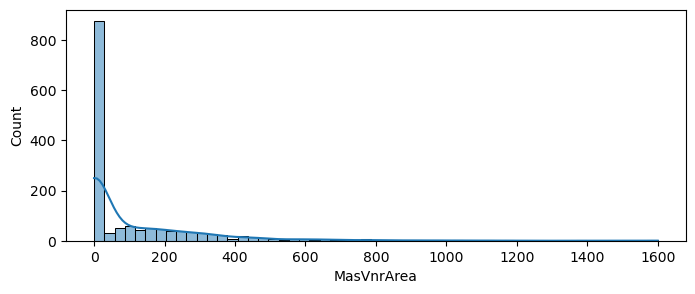

In [248]:
plt.figure(figsize=(8, 3))
sns.histplot(df['MasVnrArea'].dropna(), kde=True)

- There are a lot of zero values which correspond to absence of masonry veneer in certain houses. We just need to make sure that 8 missing values also belong to houses without masonry veneer.
- In the dataset there is a categorical feature MasVnrType which signifies which type of masonry veneer was used. 
- If in the corresponding rows there are no values, this would indicate that 8 missing values comply with the above-mentioned requirement.

In [249]:
df.loc[df['MasVnrArea'].isna(), 'MasVnrType']

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [250]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())       # fill NaNs with median which is equal 0
df['MasVnrArea'].isnull().sum()                                             # check if NaNs are filled

# The 0 values in MasVnrArea are not missing values but rather indicate that there is no masonry veneer.
# In the dataset there is already the categorical feature MasVnrType where absent veneer is indicated by the value None.
# So we already have a feature indicating the absence of masonry veneer. No need to create new one based on null values in MasVnrArea.

0

Let's check the last numerical feature containing 81 NaNs: GarageYrBlt (Year garage was built)

<Axes: xlabel='GarageYrBlt', ylabel='Count'>

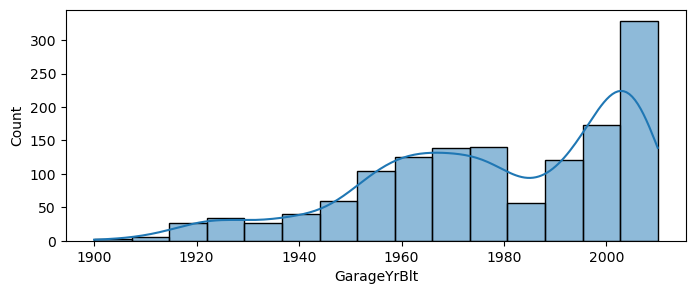

In [251]:
plt.figure(figsize=(8, 3))
sns.histplot(df['GarageYrBlt'].dropna(), kde=True)

In [252]:
# This feature has relatively hight number of NaNs and is likely to be strongly correlated with another feature (YearBuilt) which has no NaNs
# Let's check the correlation between GarageYrBlt and YearBuilt
corr = df.GarageYrBlt.corr(df["YearBuilt"])
print(f"Correlation between GarageYrBlt and YearBuilt: {corr:.3f}")

Correlation between GarageYrBlt and YearBuilt: 0.826


In [253]:
# The correlation is fairly strong -> danger of multicollinearity
# It seems justified to drop GarageYrBlt as YearBuilt must be enough to generally cover the relevant to the house age info
df = df.drop(['GarageYrBlt'], axis=1)

### Let's now deal with categorical features containing NaNs

In [254]:
cols_obj_null_count = df.select_dtypes(include='object').isnull().sum()                             # count NaNs in categorical columns
cols_obj_with_nulls = df.select_dtypes(include='object').columns[cols_obj_null_count > 0].tolist()  # list of categorical features with NaNs
df[cols_obj_with_nulls].select_dtypes(include=['object']).describe(include='all').round(2)          # describe features to better understand their quality and granularity

,Alley,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
count,91,588,1423,1423,1422,1423,1422,1459,770,1379,1379,1379,1379,7,281,54
unique,2,3,4,4,4,6,6,5,5,6,3,5,5,3,4,4
top,Grvl,BrkFace,TA,TA,No,Unf,Unf,SBrkr,Gd,Attchd,Unf,TA,TA,Gd,MnPrv,Shed
freq,50,445,649,1311,953,430,1256,1334,380,870,605,1311,1326,3,157,49


In [255]:
obj_with_nulls = df.select_dtypes(include=['object']).isnull().sum()    # count null values in remaining 'object' features
print(obj_with_nulls[obj_with_nulls > 0])                               # filter columns with null values

Alley           1369
MasVnrType       872
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


### Alley (1369 NaNs)

Alley
NaN     1369
Grvl      50
Pave      41
Name: count, dtype: int64


<Axes: xlabel='Alley', ylabel='SalePrice'>

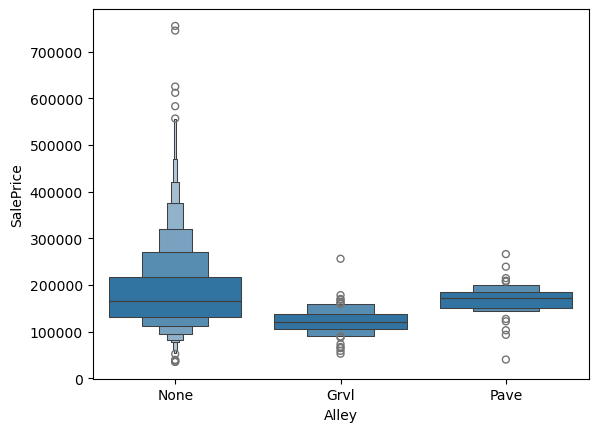

In [256]:
print(df['Alley'].value_counts(dropna=False))       # check the distribution of the Alley (Type of alley access to property: Gravel, Paved and NaN) feature
df['Alley'] = df['Alley'].fillna('None')            # fill nulls with 'None' (no alley access)
sns.boxenplot(x='Alley', y='SalePrice', data=df)    # check the distribution of SalePrice by Alley type

In [257]:
# The visually significant differences in the target justify keeping all features and distinguishing between Grvl and Pave and NoAlley.
# Use target encoding with the median SalePrice. This preserves the signal from all three categories (NoAlley, Grvl, Pave) while handling the rare categories effectively
alley_medians = df.groupby('Alley')['SalePrice'].median()
df['Alley'] = df['Alley'].map(alley_medians)
print("Median SalePrice by Alley:")
print(alley_medians)

Median SalePrice by Alley:
Alley
Grvl    119500.0
None    165000.0
Pave    172500.0
Name: SalePrice, dtype: float64


### MasVnrType (872 NaNs)

In [258]:
# Replace NaN with "None"
df['MasVnrType'] = df['MasVnrType'].fillna('None')
# Check the frequency distribution of the MasVnrType (Masonry veneer type: Brick Face, Stone, Cinder Block, None) feature
df['MasVnrType'].value_counts(dropna=False)       

MasVnrType
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [259]:
# Given the rare category BrkCmn (only 15 instances), target encoding (replacing each category with the median SalePrice for that category) seems like a good choice. 
# It handles rare categories well and keeps the feature as a single column.
masvnr_medians = df.groupby('MasVnrType')['SalePrice'].median()
df['MasVnrType'] = df['MasVnrType'].map(masvnr_medians)
print("Median SalePrice by MasVnrType:")
print(masvnr_medians)

Median SalePrice by MasVnrType:
MasVnrType
BrkCmn     139000.0
BrkFace    181000.0
None       143125.0
Stone      246839.0
Name: SalePrice, dtype: float64


### Bsmt... features (37-38 NaNs)

- BsmtQual (Evaluates the height of the basement), 
- BsmtCond (Evaluates the general condition of the basement), 
- BsmtExposure (Refers to walkout or garden level walls), 
- BsmtFinType1 (Rating of basement finished area), 
- BsmtFinType2 (Rating of basement finished area (if multiple types))

In [260]:
# Select columns that contains "bsmt" in their names
bsmt_cat_features = [col for col in df.columns if 'bsmt' in col.lower() and df[col].dtype == 'object']              # create a list of categorical features
bsmt_num_features = [col for col in df.columns if 'bsmt' in col.lower() and df[col].dtype in ['int64', 'float64']]  # for a reference create a list of numerical features as well
print(f"Categorical basement related features: {bsmt_cat_features}")
print(f"Numerical basement related features: {bsmt_num_features}")

Categorical basement related features: ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
Numerical basement related features: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']


Let's first check whether the missed categorical values correspond to some numerical ones. If there are zeroes this would most likely indicate that missing categorical values imply no basement at all.

In [261]:
# Dictionary to store results
results = {}

# Loop through each categorical feature
for feature in bsmt_cat_features:
    # Group by the categorical feature and calculate the mean of numeric features
    group_means = df.groupby(feature, dropna=False)[bsmt_num_features].mean()   # Use dropna=False to include NA as a category
    results[feature] = group_means                                              # Store the results in the dictionary

# Display the results for each categorical feature
for feature, means in results.items():
    print(f"\nMean of numeric features grouped by {feature}:")
    print(means.round(2))
    print("-" * 50)


Mean of numeric features grouped by BsmtQual:
          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtQual                                                                 
Ex            855.33       23.56     766.71      1645.60          0.68   
Fa            130.71        7.89     594.43       733.03          0.17   
Gd            472.50       34.66     623.91      1131.07          0.48   
TA            381.57       66.90     506.96       955.43          0.37   
NaN             0.00        0.00       0.00         0.00          0.00   

          BsmtHalfBath  
BsmtQual                
Ex                0.05  
Fa                0.06  
Gd                0.04  
TA                0.08  
NaN               0.00  
--------------------------------------------------

Mean of numeric features grouped by BsmtCond:
          BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
BsmtCond                                                                 
Fa           

- For all categorical features (BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2), when the value is NaN, the numerical features are mostly 0, except for small values in BsmtExposure and BsmtFinType2 (e.g., BsmtUnfSF = 24.63 for BsmtExposure = NaN).
- This strongly suggests that NaN means "No Basement," and the small non-zero values might be data inconsistencies (e.g., a small unfinished area recorded but no basement quality specified).
- Given the small proportion of missing values and the discovered relationship with numerical features let's just replace NaNs with 'NA'. This would allows the model to treat it as a valid category meaning "No Basement".

In [262]:
# Replace NaN with "NA"
for feature in bsmt_cat_features:
    df[feature] = df[feature].fillna('NA')

# Verify no more missing values
print("Missing values after replacement:")
print(df[bsmt_cat_features].isnull().sum())

Missing values after replacement:
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64


- Now we need to encode them into a numerical format for modeling. Options include ordinal encoding (if the categories have a natural order), one-hot encoding, or target encoding.
- Ordinal encoding could be a possibility but can be somewhat subjective.
- One-hot-encoding would create a lot of dummies which would expand the model dimensionality too much.
- The best choice can be again target-encoding which implies replacing each subcategory with the median (the target has rather skewed distribution) SalePrice for it. This captures the relationship with the target directly, keeps each feature as a single column, and handles rare categories well (e.g., Po in BsmtCond has few instances).

In [263]:
# Target encode each categorical feature using median SalePrice
for feature in bsmt_cat_features:
    medians = df.groupby(feature)['SalePrice'].median()     # Compute median SalePrice for each category
    df[feature] = df[feature].map(medians)                  # Map the medians to the feature values

In [264]:
# Check the resulting formerly categorical (now numerical) Basement-related features
df[bsmt_cat_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BsmtQual      1460 non-null   float64
 1   BsmtCond      1460 non-null   float64
 2   BsmtExposure  1460 non-null   float64
 3   BsmtFinType1  1460 non-null   float64
 4   BsmtFinType2  1460 non-null   float64
dtypes: float64(5)
memory usage: 57.2 KB


In [265]:
# Check the resulting numerical Basement-related features
df[bsmt_num_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   BsmtFinSF1    1460 non-null   int64
 1   BsmtFinSF2    1460 non-null   int64
 2   BsmtUnfSF     1460 non-null   int64
 3   TotalBsmtSF   1460 non-null   int64
 4   BsmtFullBath  1460 non-null   int64
 5   BsmtHalfBath  1460 non-null   int64
dtypes: int64(6)
memory usage: 68.6 KB


### Electrical feature (1 NaN)

In [266]:
# Check the distribution of the Electrical (Electrical system: SBrkr, FuseA, FuseF, FuseP, Mix) feature
df['Electrical'].value_counts(dropna=False)      

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: count, dtype: int64

Given that SBrkr is the overwhelming majority (>90%), the most likely value for the missing entry is SBrkr.

In [267]:
# Impute NaN with the mode
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# Verify no missing values remain
print("Missing values after imputation:")
print(df['Electrical'].isnull().sum())

Missing values after imputation:
0


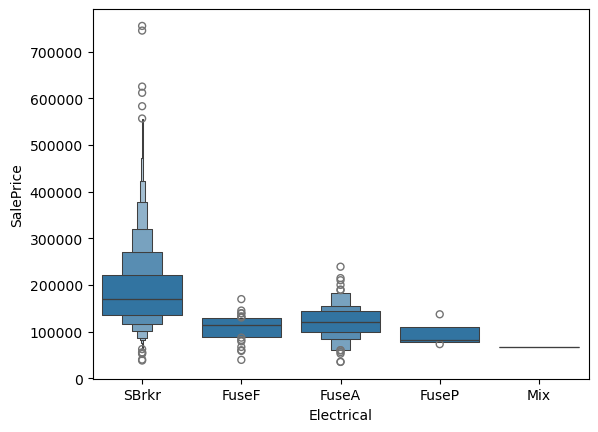

In [268]:
# Check the distribution of SalePrice by Electrical type
sns.boxenplot(x='Electrical', y='SalePrice', data=df)    # Check the distribution of SalePrice by Electrical type
plt.show()

Taking into consideration that SBrkr is the modern standard (circuit breakers), while FuseA, FuseF, and FuseP indicate older fuse box systems with varying capacities and wiring types (Mix indicates a combination of systems) and that there is a clear differentiation between SBrkr and others by SalePrice, it seems reasonable to transform the feature to a binary type.

In [269]:
# Create a binary feature: 1 for SBrkr, 0 for others
df['Electrical'] = (df['Electrical'] == 'SBrkr').astype(int)

# Check the distribution
print(df['Electrical'].value_counts())

Electrical
1    1335
0     125
Name: count, dtype: int64


### FireplaceQu (690 NaNs)

In [270]:
df.FireplaceQu.value_counts(dropna=False)       # check the distribution of the FireplaceQu (Fireplace quality: Ex, Gd, TA, Fa, Po, NA) feature

FireplaceQu
NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: count, dtype: int64

- NaN: 690 (47.3%) – Likely means "No Fireplace"
- Gd (Good): 380 (26.0%)
- TA (Average): 313 (21.4%)
- Fa (Fair): 33 (2.3%)
- Ex Excellent): 24 (1.6%)
- Po (Poor): 20 (1.4%)

In [271]:
# Replace NaN with 'NA' (no fireplace)
df['FireplaceQu'] = df['FireplaceQu'].fillna('NA')

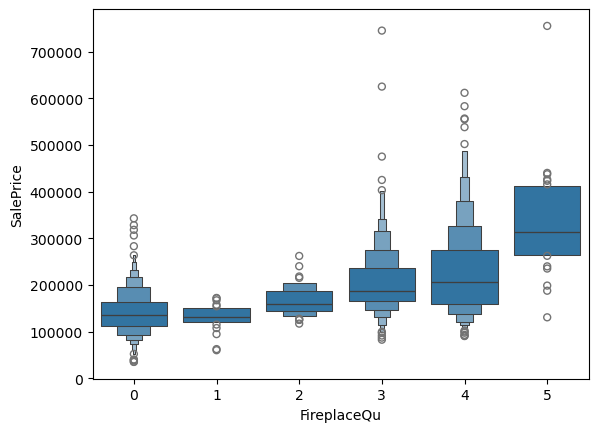

In [272]:
# The feature has a clear ordinal nature. Let's define the order of the categories
ordinal_mapping = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['FireplaceQu'] = df['FireplaceQu'].map(ordinal_mapping)    # Map the ordinal values to the feature

sns.boxenplot(x='FireplaceQu', y='SalePrice', data=df)    # Check the distribution of SalePrice by FireplaceQu type
plt.show()

# Looks good! Almost each following category has a higher median SalePrice than the previous one.

### GarageType, GarageFinish, GarageQual, GarageCond (81 NaNs each)

In [273]:
garage_features = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'] # list of categorical features
df[garage_features].describe(include='all')    # describe features to better understand their quality and granularity

,GarageType,GarageFinish,GarageQual,GarageCond
count,1379,1379,1379,1379
unique,6,3,5,5
top,Attchd,Unf,TA,TA
freq,870,605,1311,1326


In [274]:
# Check another Garage-related feature (with no NaNs) to explore the pattern of missing values
df.GarageArea[df.GarageArea == 0].count()    # count the number of 0 values in GarageArea
print(f"GarageArea has {df.GarageArea[df.GarageArea == 0].count()} rows with 0 values")

GarageArea has 81 rows with 0 values


In [275]:
# It is now clear that missing values correspond to the absence of a garage.
# Impute NaNs with 'NA' (no garage)
for feature in garage_features: 
    df[feature] = df[feature].fillna('NA')

In [276]:
# Check 'GarageType' distribution
df['GarageType'].value_counts()

GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

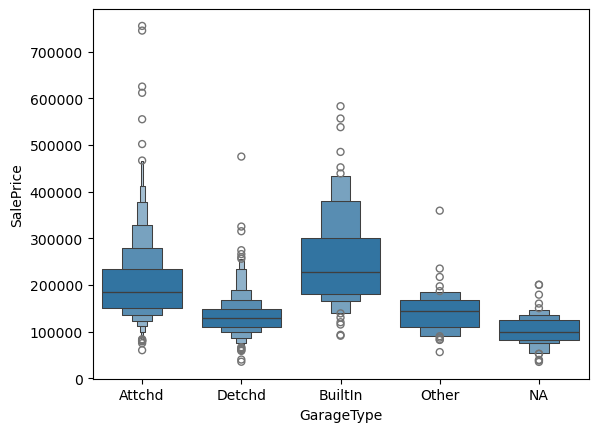

In [277]:
# Due to some very rare subcategories let's combine Basment (19), CarPort (9), 2Types (6) into "Other"
df['GarageType'] = df['GarageType'].replace({'Basment': 'Other', 'CarPort': 'Other', '2Types': 'Other'})
sns.boxenplot(x='GarageType', y='SalePrice', data=df)    # Check the distribution of SalePrice by GarageType type
plt.show()

In [278]:
# Use target encoding (median SalePrice per category) to capture the relationship with SalePrice
medians = df.groupby('GarageType')['SalePrice'].median()     # Compute median SalePrice for each category
df['GarageType'] = df['GarageType'].map(medians)             # Map the medians to the feature values

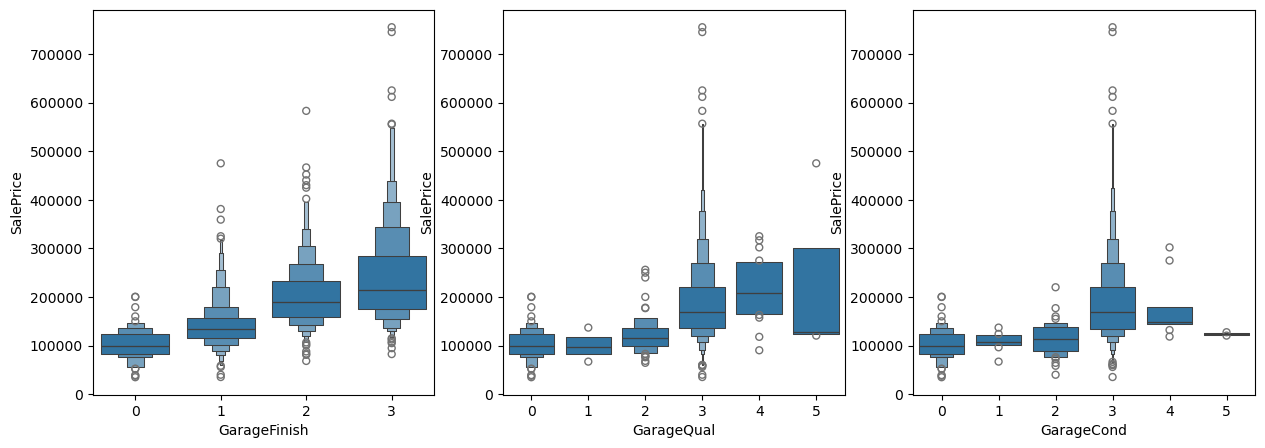

In [279]:
# 'GarageFinish', 'GarageQual', 'GarageCond' are ordinal features. Let's define the order of the categories

# For GarageFinish the sequence is: NA < Unf < RFn < Fin:
ordinal_mapping1 = {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
df['GarageFinish'] = df['GarageFinish'].map(ordinal_mapping1)    # Map the ordinal values to the feature

# For GarageQual and GarageCond the sequence is the same as for FireplaceQu:
ordinal_mapping2 = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['GarageQual'] = df['GarageQual'].map(ordinal_mapping2)    # Map the ordinal values to the feature
df['GarageCond'] = df['GarageCond'].map(ordinal_mapping2)    # Map the ordinal values to the feature

# Check the distribution of SalePrice by ordinal Garage-related features
figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.boxenplot(x='GarageFinish', y='SalePrice', data=df, ax=ax1)    
sns.boxenplot(x='GarageQual', y='SalePrice', data=df, ax=ax2)    
sns.boxenplot(x='GarageCond', y='SalePrice', data=df, ax=ax3)    
plt.show()

### PoolQC (1453 NaNs)


In [280]:
# check the distribution of the PoolQC (Pool quality: Ex, Gd, TA, Fa, NA) feature
df.PoolQC.value_counts(dropna=False)

PoolQC
NaN    1453
Gd        3
Ex        2
Fa        2
Name: count, dtype: int64

In [281]:
# Missing values are massive. Let's check another associated with PoolQC numeric feature: PoolArea
df.PoolArea[df.PoolArea == 0].count()    # count the number of 0 values in PoolArea

1453

The prognostic power of both features is extremely small. It seems justified to drop them off.

In [282]:
df = df.drop(['PoolQC', 'PoolArea'], axis=1)    # drop PoolQC and PoolArea as completely uninformative

### Fence (1179 NaNs)

In [283]:
df.Fence.value_counts(dropna=False) # check the distribution of the Fence (Fence quality: GdWo, MnPrv, GdPrv, NA) feature

"""
GdPrv:	Good Privacy
MnPrv:	Minimum Privacy
GdWo:	Good Wood
MnWw:	Minimum Wood/Wire
NA:	    No Fence
"""

'\nGdPrv:\tGood Privacy\nMnPrv:\tMinimum Privacy\nGdWo:\tGood Wood\nMnWw:\tMinimum Wood/Wire\nNA:\t    No Fence\n'

<Axes: xlabel='Fence', ylabel='SalePrice'>

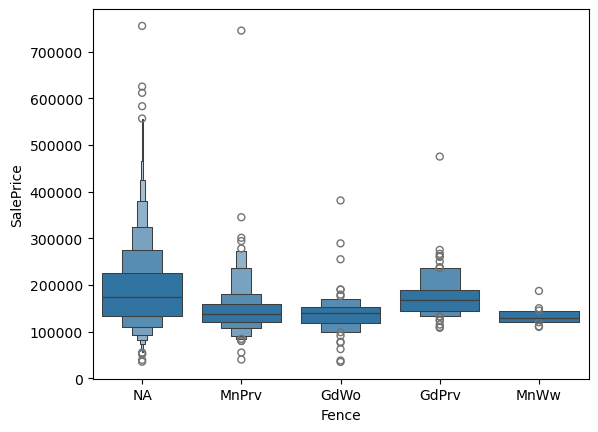

In [284]:
# It is clear that NaNs correspond to the absence of a fence
# Impute NaNs with 'NA' (no fence)
df['Fence'] = df['Fence'].fillna('NA')
sns.boxenplot(x='Fence', y='SalePrice', data=df)    # Check the distribution of SalePrice by Fence type

- The number of missing values is very high. Among rare features only GdPrv (Fence with good privacy) seems to be associated with higher SalesPrice.
- On the other hand, it look no much different from the very large group of "No Fence".
- It seems justified to drop this feature from the model.

In [285]:
df = df.drop(['Fence'], axis=1)    # drop Fence as completely uninformative

### MiscFeature (1406 NaNs)

In [286]:
df.MiscFeature.value_counts(dropna=False) # check the distribution of the MiscFeature (Miscellaneous feature: Tenis Court, Shed, NA) feature

"""
Elev	Elevator
Gar2	2nd Garage (if not described in garage section)
Othr	Other
Shed	Shed (over 100 SF)
TenC	Tennis Court
NA	None
"""

'\nElev\tElevator\nGar2\t2nd Garage (if not described in garage section)\nOthr\tOther\nShed\tShed (over 100 SF)\nTenC\tTennis Court\nNA\tNone\n'

<Axes: xlabel='MiscFeature', ylabel='SalePrice'>

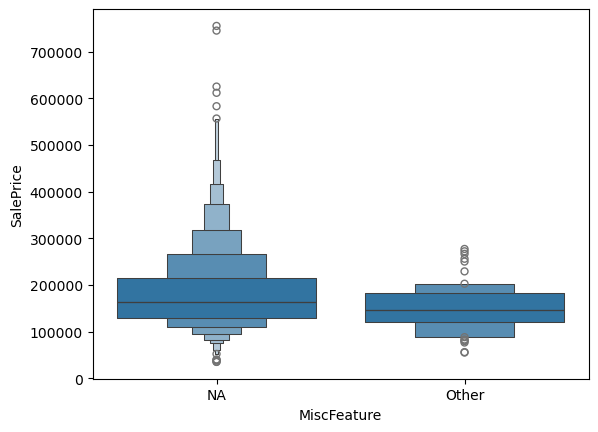

In [287]:
# It is reasonable to join all subcategories into "Other" and impute NaNs with 'NA' (no miscellaneous feature)
df['MiscFeature'] = df['MiscFeature'].replace({'Elev': 'Other', 'Gar2': 'Other', 'Othr': 'Other', 'Shed': 'Other', 'TenC': 'Other'})
df['MiscFeature'] = df['MiscFeature'].fillna('NA')    # fill NaNs with 'NA' (no miscellaneous feature)
sns.boxenplot(x='MiscFeature', y='SalePrice', data=df)    # Check the distribution of SalePrice by MiscFeature type

In [288]:
df_na_count = df.isnull().sum()    # check if there are any missing values left in the dataset
print(f"Missing values in the dataset:\n{df_na_count[df_na_count > 0]}")    # filter columns with NaNs

Missing values in the dataset:
Series([], dtype: int64)



---

## **2. Exploratory Data Analysis (EDA)**

### Question 3: Describe the dataset's numerical features.
- Use `describe()` to get a summary of the dataset's numerical columns.
- Which feature(s) have the highest and lowest values? Are there any surprising observations?

In [289]:
df.select_dtypes(include='number').describe().round(2)    # check the basic descriptive statistics for numerical features

,Id,MSSubClass,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrType,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice,LotFrontage_missing
count,1460.00,1460.0,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,...,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0,1460.00
mean,730.50,56.9,70.57,10516.83,163652.40,6.10,5.58,1971.27,1984.87,163719.45,...,94.24,46.66,21.95,3.41,15.06,43.49,6.32,2007.82,180921.2,0.18
std,421.61,42.3,23.30,9981.26,8408.98,1.38,1.11,30.20,20.65,30935.02,...,125.34,66.26,61.12,29.32,55.76,496.12,2.70,1.33,79442.5,0.38
min,1.00,20.0,21.00,1300.00,119500.00,1.00,1.00,1872.00,1950.00,139000.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.0,0.00
25%,365.75,20.0,60.00,7553.50,165000.00,5.00,5.00,1954.00,1967.00,143125.00,...,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.0,0.00
50%,730.50,50.0,70.00,9478.50,165000.00,6.00,5.00,1973.00,1994.00,143125.00,...,0.00,25.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.0,0.00
75%,1095.25,70.0,80.00,11601.50,165000.00,7.00,6.00,2000.00,2004.00,181000.00,...,168.00,68.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.0,0.00
max,1460.00,190.0,313.00,215245.00,172500.00,10.00,9.00,2010.00,2010.00,246839.00,...,857.00,547.00,552.00,508.00,480.00,15500.00,12.00,2010.00,755000.0,1.00


In [290]:
df = df.drop('Id', axis=1)    # drop the Id column as it is not informative for prediction
df_num_features = df.select_dtypes(include='number').columns.tolist()    # list of left numerical features
print(f"At the moment we have {len(df_num_features)} numerical features in the dataframe out of {df.shape[1]} total features")

At the moment we have 49 numerical features in the dataframe out of 77 total features


The number of numeric features is large. Many features have very different magnitudes of variability. Some have very different from normal distributions.

### Question 4: Visualize the distribution of house prices.
- Create a histogram of the house prices. Is the distribution normal or skewed?

Skewness of SalePrice: 1.88


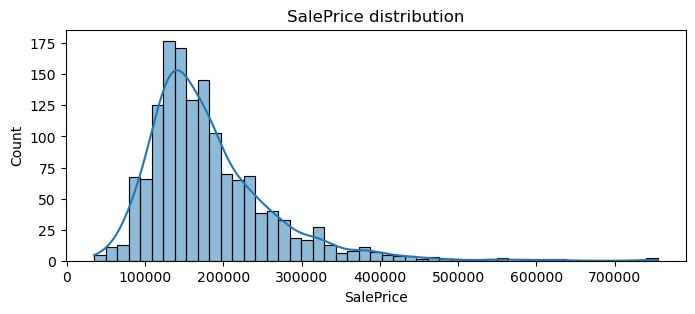

In [291]:
# Check the skewness and distribution of the target variable SalePrice
skewness = skew(df['SalePrice'])
print(f"Skewness of SalePrice: {skewness:.2f}")

plt.figure(figsize=(8, 3))
sns.histplot(df['SalePrice'], kde=True)
plt.title('SalePrice distribution')
plt.show()

The target's distribution is mostly right-skewed, with a long tail on right side, indicating that there are a few cases of very expensive houses in the dataset.


### Question 5: Explore relationships between features and house prices.
- Create scatter plots for at least 3 features vs. house prices (target variable).
- What relationships do you observe between the selected features and the target?


In [ ]:
corr_matrix = df.select_dtypes(include='number').corr().round(3)        # Select numerical features and compute the correlation matrix
corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10)    # Extract strongest correlations with SalePrice and sort by absolute value

SalePrice       1.000
OverallQual     0.791
GrLivArea       0.709
BsmtQual        0.681
GarageCars      0.640
GarageArea      0.623
TotalBsmtSF     0.614
1stFlrSF        0.606
FullBath        0.561
GarageFinish    0.549
Name: SalePrice, dtype: float64

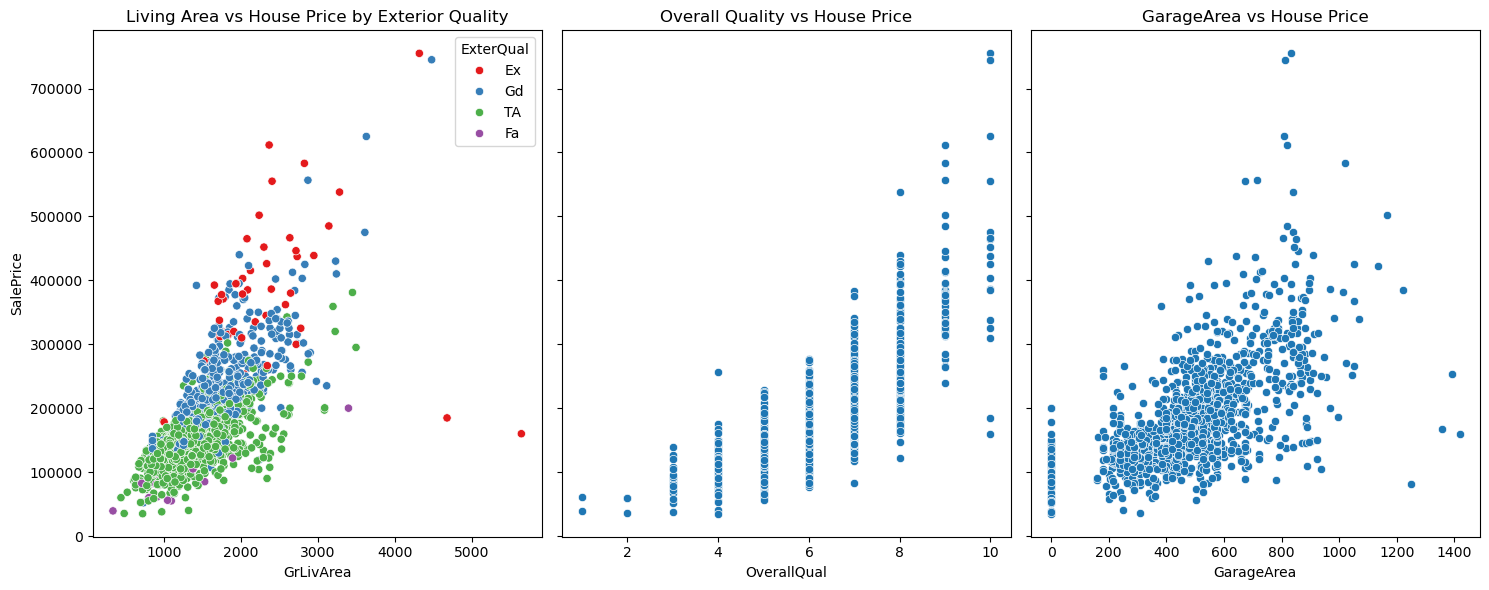

In [310]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

exterqual_order = ['Ex', 'Gd', 'TA', 'Fa']

sns.scatterplot(df, x='GrLivArea', y='SalePrice', hue='ExterQual', hue_order=exterqual_order, palette='Set1', ax=ax1)    
ax1.set_title('Living Area vs House Price by Exterior Quality')
sns.scatterplot(df, x='OverallQual', y='SalePrice', ax=ax2)
ax2.set_title('Overall Quality vs House Price')
ax2.set_ylabel('')
ax2.set_yticklabels([])
sns.scatterplot(df, x='GarageArea', y='SalePrice', ax=ax3)
ax3.set_title('GarageArea vs House Price')
ax3.set_ylabel('')
ax3.set_yticklabels([])
plt.tight_layout()
plt.show()


The depicted scatterplots represent relatively strong positive correlations between house selling price and such variables as Living Area (moderated by Exterior Quality), Overall Quality of the house and Garage Area. They must have the strongest predictive power for our model.


---

## **3. Feature Selection**

### Question 6: Correlation Analysis
- Calculate the correlation matrix of the dataset.
- Based on the correlation, identify at least 2 features that are highly correlated with house prices.
- Are there any features that are strongly correlated with each other but not with the target?



---

## **4. Regression Modeling**

### Question 7: Split the dataset
- Split the dataset into training and testing sets. Use an 80/20 split.
- Make sure to separate the target variable (house prices) from the features.

### Question 8: Train a Linear Regression Model
- Train a Linear Regression model using the training data.
- Evaluate the model's performance on the test data by calculating the Mean Squared Error (MSE).

### Question 9: Feature Importance (Optional)
- If using a model like Ridge or Lasso, identify which features are most important in predicting house prices.

---

## **5. Conclusion**
- Summarize your findings and observations.
- Reflect on the regression model's performance and whether there are any improvements you would recommend.